In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from analcisprop.constants import *
import analcisprop.utils.variable_changes as vc

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

from p_tqdm import p_map

### Initial Conditions

In [3]:
# osculating elements
akm = RL + 300
ecc0 = 0.1
inc0 = 15*deg
om0 = -0.4
OM0 = 0.7
M0 = -0.3

tmax = 100
dt = 1
tgrid = np.linspace(0.0, tmax, int(1 + tmax/dt), endpoint = True)

# Cartesian Integration

In [4]:
import analcisprop.propagators.cartesian_propagator as crt


Heyoka Taylor integrator:
 C++ datatype            : double
Tolerance               : 2.220446049250313e-16
High accuracy           : false
Compact mode            : true
Taylor order            : 20
Dimension               : 6
Time                    : 0
State                   : [2500, 456, 975, 1265, 345, 2356]


Taylor order:
 476


In [5]:
ic0 = vc.par2ic([akm, ecc0, inc0, OM0, om0, M0], GML)
sol = crt.propagate(tmax, dt, ic0)

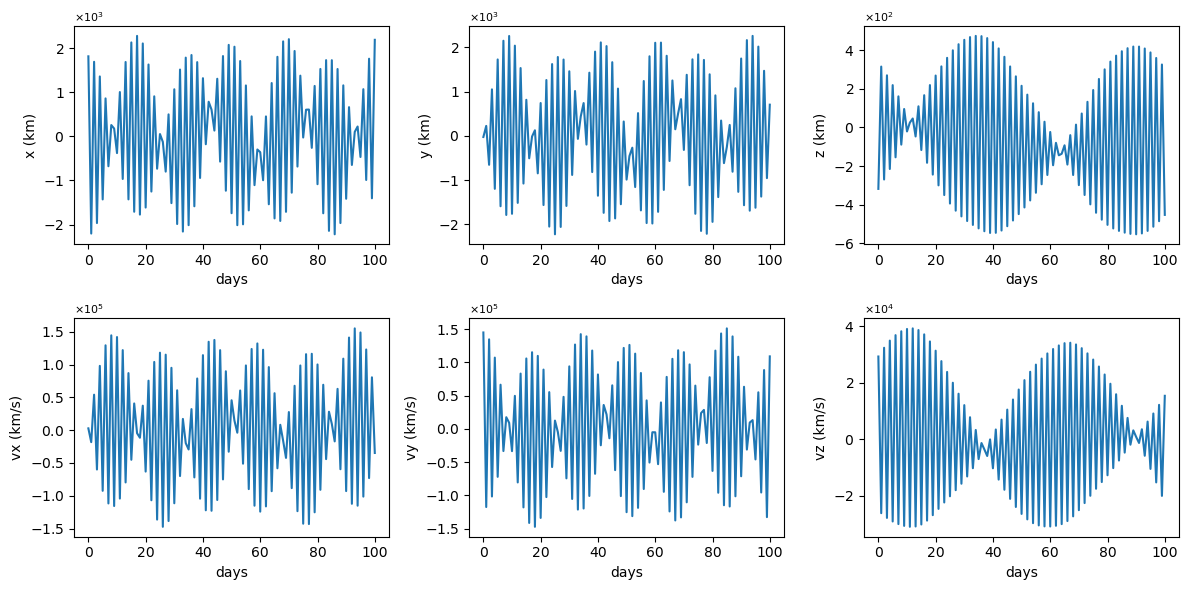

In [6]:
plt.figure(figsize=(12, 6))

cartesian_var_names = ['x (km)', 'y (km)', 'z (km)', 'vx (km/s)', 'vy (km/s)', 'vz (km/s)']

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol[:, i])
    plt.ylabel(cartesian_var_names[i])
    plt.xlabel('days')
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

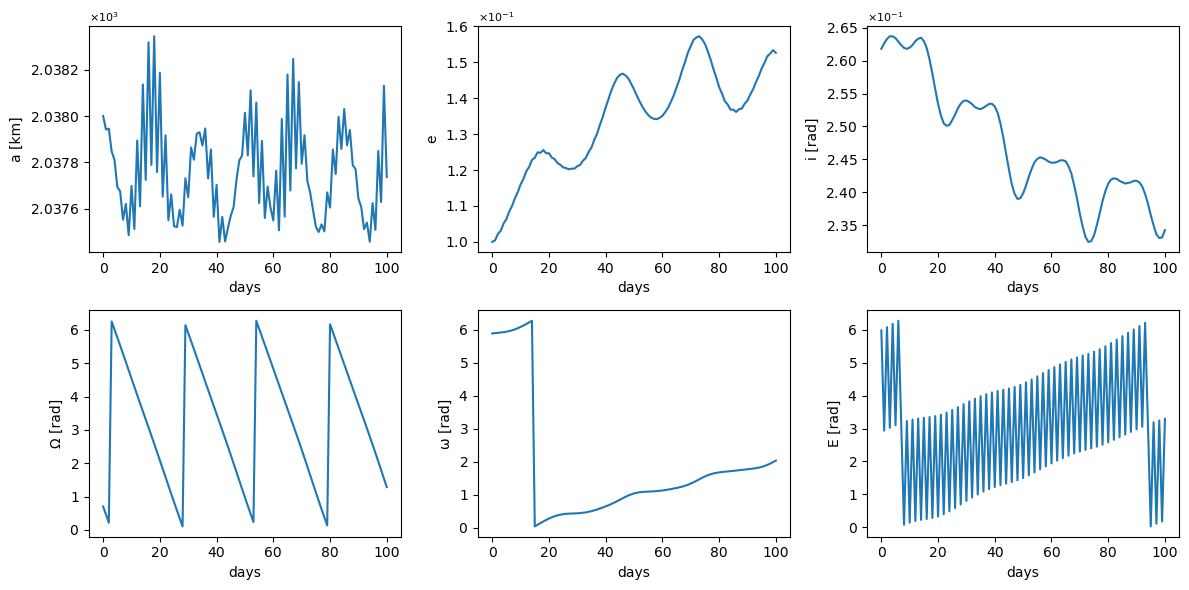

In [7]:
sol_kep = np.array([vc.ic2par(sol[j], GML) for j in range(len(sol))])

kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'E [rad]']

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol_kep[:, i])
    plt.ylabel(kep_var_names[i])
    plt.xlabel('days')
    
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

In [8]:
def cart2mean(j):
    [a, ecc, inc, OM, om, ecc_an] = sol_kep[j]
    t = tgrid[j]
    mean_an = vc.E2M(ecc_an, ecc)
    osc_kep = [a, ecc, inc, OM, om, mean_an]
    mean_kep = vc.osc2mean(osc_kep, t)
    return mean_kep


In [9]:
mean_cart = np.array(p_map(cart2mean, range(len(tgrid))))

  0%|          | 0/101 [00:00<?, ?it/s]

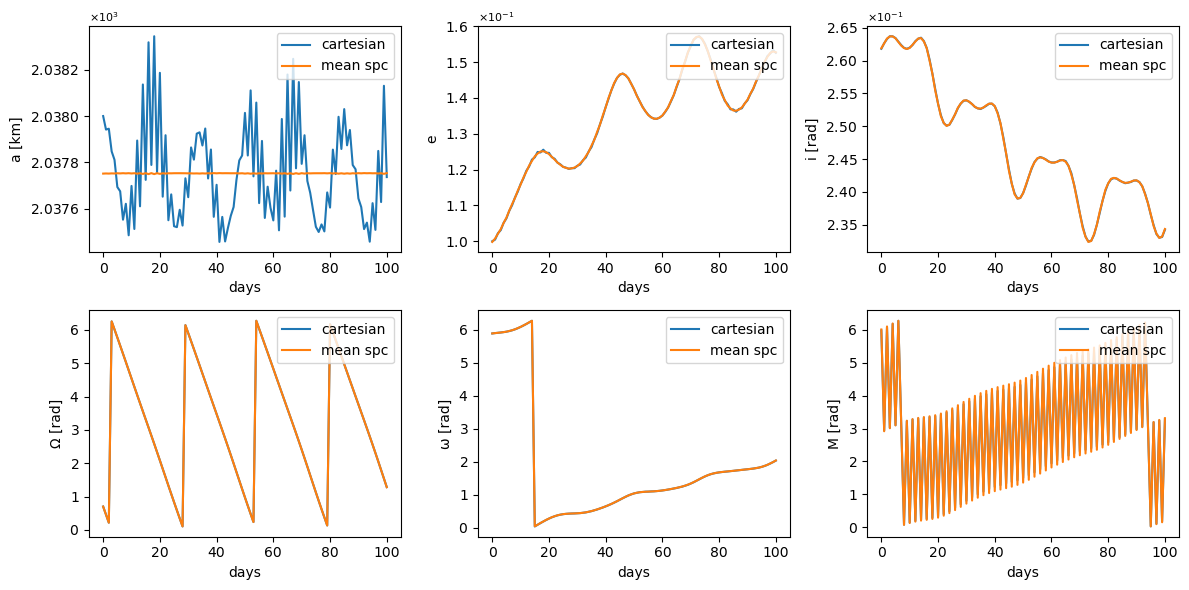

In [10]:
sol_kep = np.array([vc.ic2par(sol[j], GML) for j in range(len(sol))])

kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'M [rad]']

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol_kep[:, i], label = 'cartesian')
    plt.plot(tgrid, mean_cart[:, i], label = 'mean spc')
    plt.ylabel(kep_var_names[i])
    plt.xlabel('days')
    plt.legend(loc = 'upper right')
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

# Secular Integration

In [11]:
import analcisprop.propagators.secular_propagator as sec_sp

In [12]:
# find mean initial conditions
[akm_mean, ecc0_mean, inc0_mean, OM0_mean, om0_mean, M0_mean] = vc.osc2mean([akm, ecc0, inc0, OM0, om0, M0], 0.0)
ic0_eq = np.array(vc.kep2equinox([akm_mean, ecc0_mean, inc0_mean, OM0_mean, om0_mean, M0_mean]))

In [13]:
solver_options = {
    'method': 'LSODA',
    't_eval': tgrid,
    'rtol': 1e-8,
    'atol': 1e-8
}
t_span=(0, tmax)

sec_sol_eq = sec_sp.propagate(ic0_eq, t_span, **solver_options)

In [14]:
sol_sec_kep_list = []

for j in range(sec_sol_eq.y.shape[1]):
    equinoctial_state = sec_sol_eq.y[:, j]

    keplerian_state = vc.equinox2kep(equinoctial_state)

    # Append the result to the list
    sol_sec_kep_list.append(keplerian_state)

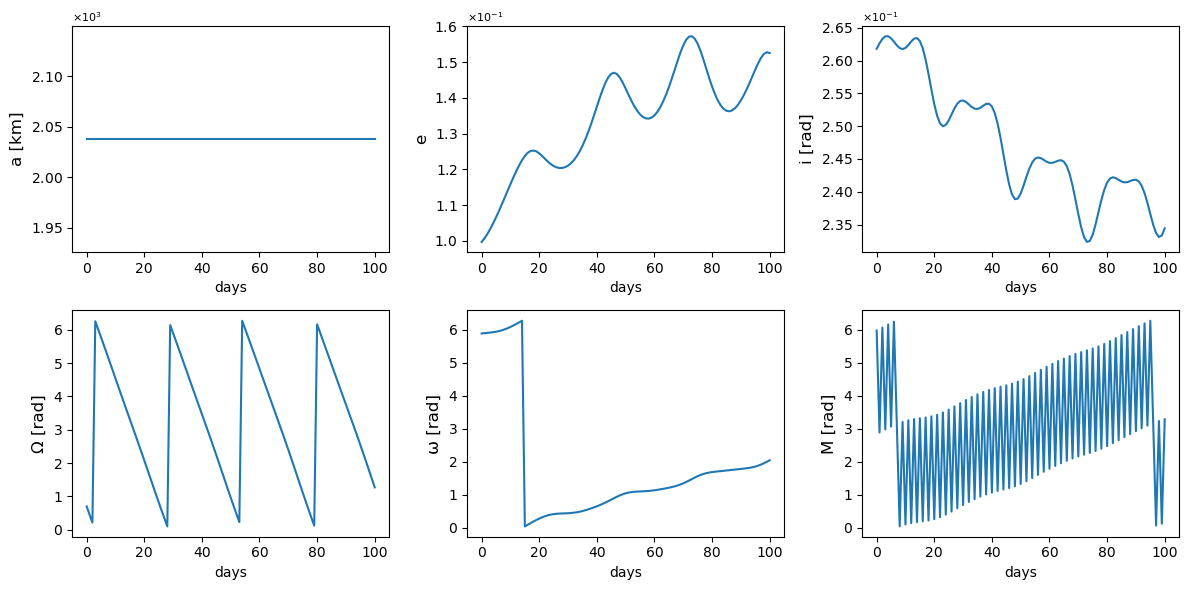

In [15]:
kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'M [rad]'] # Added 'a' and 'M'
plt.figure(figsize=(12, 6))
for i in range(6): # Loop through all 6 Keplerian elements
    plt.subplot(2, 3, i+1)
    # Use sol_sec_eq.t for the time axis
    plt.plot(sec_sol_eq.t, np.array(sol_sec_kep_list)[:, i])
    plt.ylabel(kep_var_names[i], fontsize = 12)
    plt.xlabel('days')

    # Optional: Add formatting like in other plots
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))

plt.tight_layout()
plt.show()

# Comparisons

In [16]:
sol_sec_kep_arr = np.array(sol_sec_kep_list)

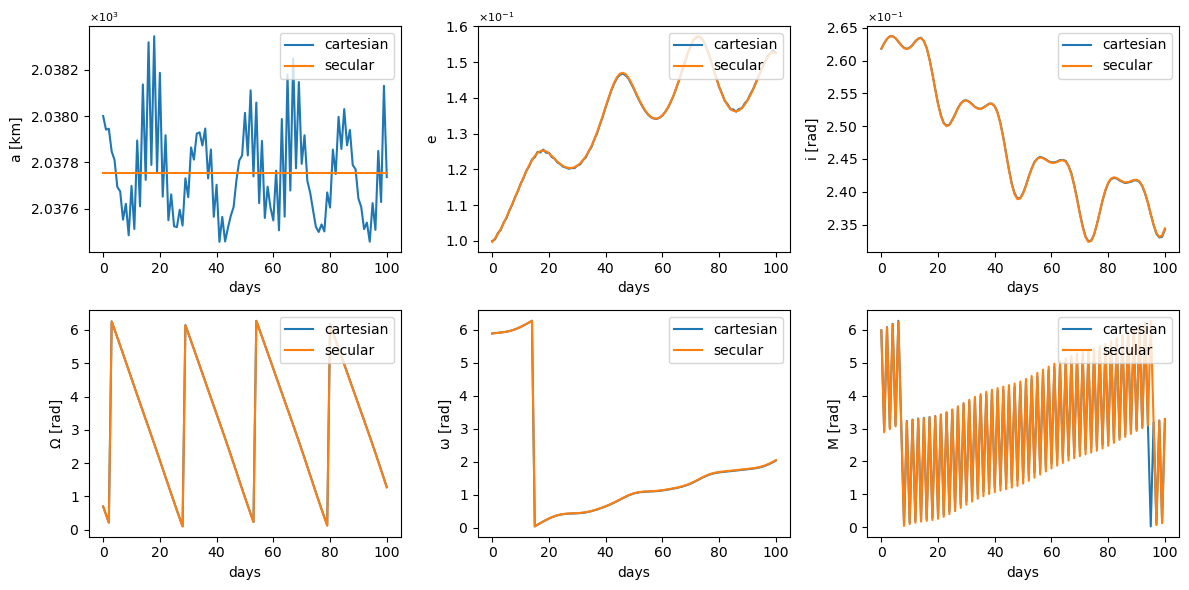

In [17]:
kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'M [rad]']

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol_kep[:, i], label = 'cartesian')
    plt.plot(tgrid, sol_sec_kep_arr[:, i], label = 'secular')
    plt.ylabel(kep_var_names[i])
    plt.xlabel('days')
    plt.legend(loc = 'upper right')
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

# SPC correctios

In [18]:
def sec2osc(j):
    [a, ecc, inc, OM, om, mean_an] = sol_sec_kep_arr[j] 
    mean_kep = [a, ecc, inc, OM, om, mean_an]
    t = tgrid[j]
    osc_kep = vc.mean2osc(mean_kep, t)
    return osc_kep

In [19]:
osc_sec = np.array(p_map(sec2osc, range(len(tgrid))))

  0%|          | 0/101 [00:00<?, ?it/s]

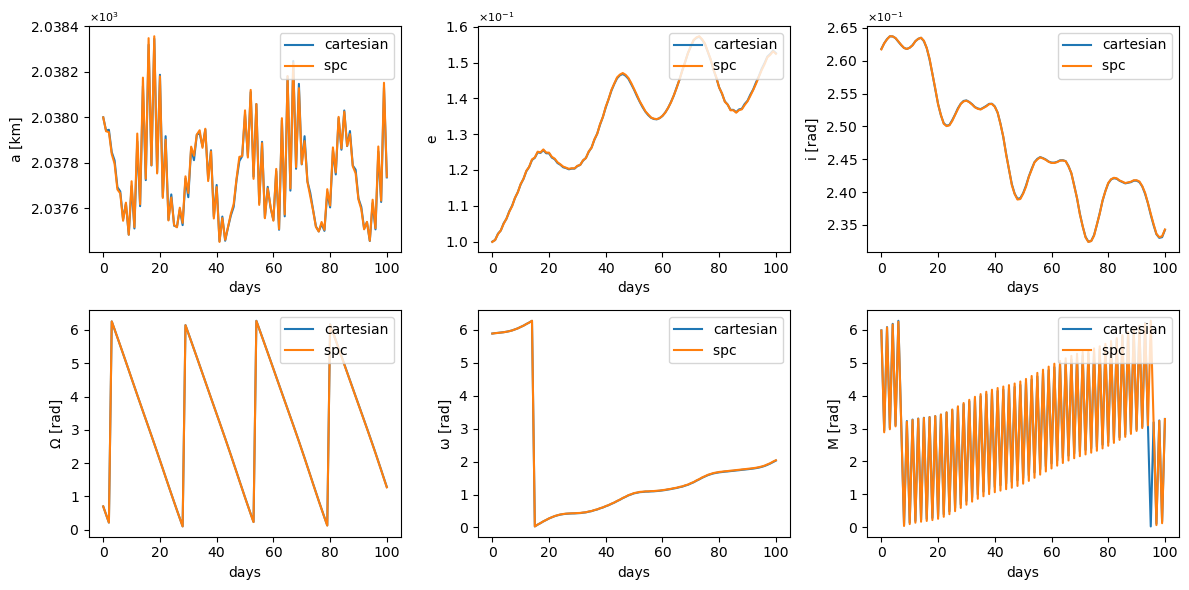

In [20]:
kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'M [rad]']

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol_kep[:, i], label = 'cartesian')
    plt.plot(tgrid, osc_sec[:, i], label = 'spc ')
    plt.ylabel(kep_var_names[i])
    plt.xlabel('days')
    plt.legend(loc = 'upper right')
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

# Analytic Solution

In [21]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wlexpr

session = WolframLanguageSession()

In [22]:
session.evaluate(wlexpr(
    'Get[FileNameJoin[{Directory[], "analcisprop","propagators", "NormalForm.m" }]]'
    ));

In [23]:
analytic_eq = np.array(session.evaluate(
    wlexpr(f'AnalyticEquinoctical[ {{ {akm_mean}, {ecc0_mean}, {inc0_mean}, {OM0_mean}, {om0_mean}, {M0_mean} }}, {{ {0.0}, {tmax}, {dt} }}]')
    ))

In [24]:
analytic_kep = np.array([vc.equinox2kep(analytic_eq[j]) for j in range(len(analytic_eq))])

In [25]:
efun_str, ifun_str = session.evaluate(
    wlexpr(f'AnalyticEccInc[{akm_mean}, {ecc0_mean}, {inc0_mean}, {OM0_mean}, {om0_mean}, {M0_mean}]')
    )

def string_to_function(expr):
    def func(t):
        return eval(expr, {"np": np, "t": t})
    return func
eanal = string_to_function(efun_str)
ianal = string_to_function(ifun_str)


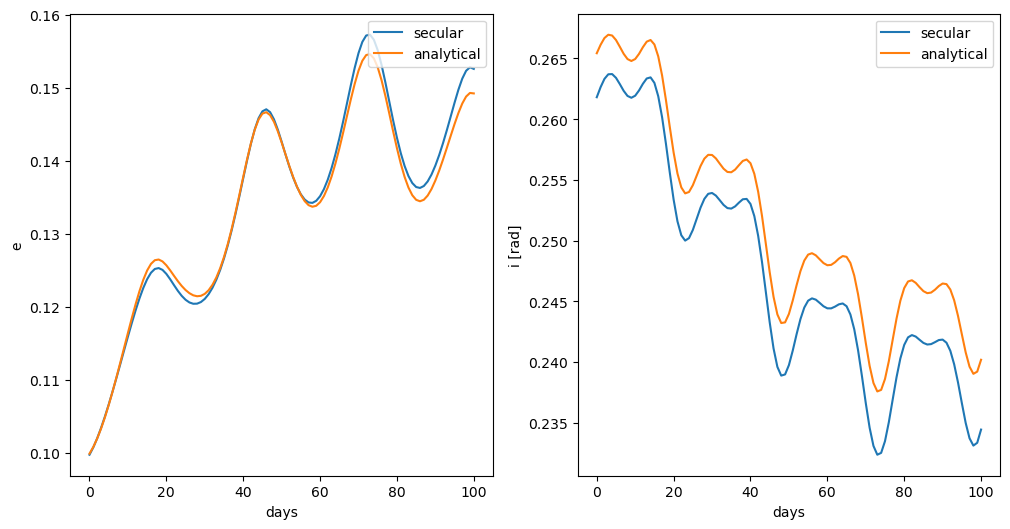

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(tgrid, sol_sec_kep_arr[:, 1], label = 'secular')
plt.plot(tgrid, p_map(eanal, tgrid, disable=True), label = 'analytical')
plt.ylabel('e')
plt.xlabel('days')
plt.legend(loc = 'upper right')

plt.subplot(1, 2, 2)
plt.plot(tgrid, sol_sec_kep_arr[:, 2], label = 'secular')
plt.plot(tgrid, np.array(p_map(ianal, tgrid, disable=True)), label = 'analytical')
plt.ylabel('i [rad]')
plt.xlabel('days')
plt.legend(loc = 'upper right')


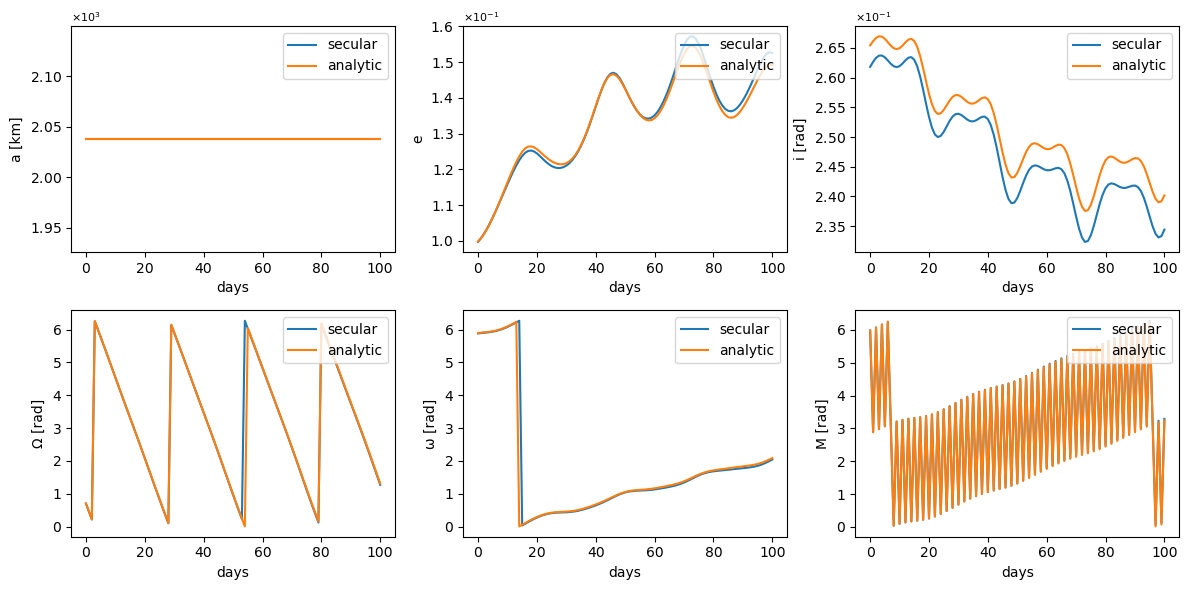

In [27]:
kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'M [rad]']

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol_sec_kep_arr[:, i], label = 'secular')
    plt.plot(tgrid, analytic_kep[:, i], label = 'analytic')
    plt.ylabel(kep_var_names[i])
    plt.xlabel('days')
    plt.legend(loc = 'upper right')
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

In [28]:
def anal2osc(j):
    [akm, ecc, inc, OM, om, mean_an] = analytic_kep[j] 
    mean_kep = [akm, ecc, inc, OM, om, mean_an]
    t = tgrid[j]
    osc_kep = vc.mean2osc(mean_kep, t)
    return osc_kep


In [29]:
osc_anal = np.array(p_map(anal2osc, range(len(tgrid))))

  0%|          | 0/101 [00:00<?, ?it/s]

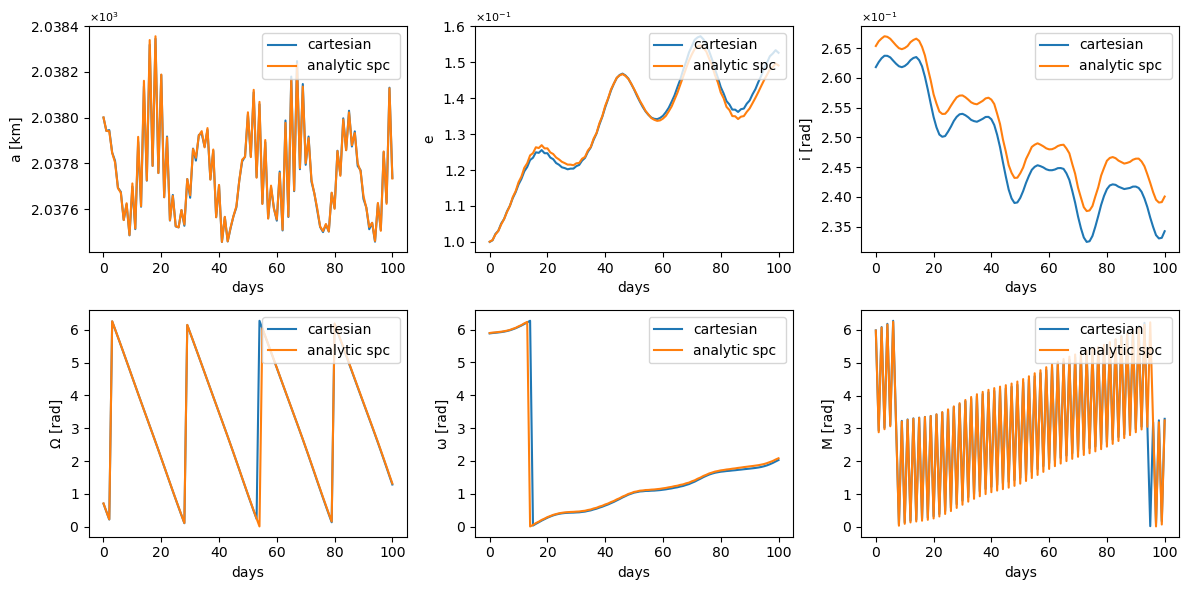

In [30]:
kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'M [rad]']

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol_kep[:, i], label = 'cartesian')
    plt.plot(tgrid, osc_anal[:, i], label = 'analytic spc ')
    plt.ylabel(kep_var_names[i])
    plt.xlabel('days')
    plt.legend(loc = 'upper right')
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

## Time of integration

In [31]:
tmax = 5*365.
print('Cartesian')
%timeit crt.propagate(tmax, dt, ic0)

print('\nEquinoctical')
%timeit sec_sp.propagate(ic0_eq, t_span, **solver_options)

print('\nAnalytic')
%timeit  np.array(session.evaluate(wlexpr(f'AnalyticEquinoctical[ {{ {akm_mean}, {ecc0_mean}, {inc0_mean}, {OM0_mean}, {om0_mean}, {M0_mean} }}, {{ {0.0}, {tmax}, {dt} }}]')))

Cartesian
9.01 s ± 52.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Equinoctical
1.3 s ± 824 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

Analytic
1.87 s ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
session.terminate()